# Deep Ellipse

> NOTES FOR RUNNING:
> * Make sure the notebook is run from a folder that has an `images` sub-dir with the data (see README)
> * There are some dependencies between cells - some cells may depend on code in previous cells

Building an ellipse **classifier** is a no-brainer. A model with 3 (3x3) conv layers, (2x2) max-pooling in between, and a fully-connected layer (size 512x1) on top was more than enough to quickly train a high accuracy classifier (>0.95 accuracy) from scratch. Regression of the parameters was by far the bigger challenge.

The outrageous simplicity with which this ellipse-fitting task can be achieved using out-of-the-box computer vision techniques is seriously aggravating. This did cause me to spend a bit of time contemplating whether I can mimic the obvious approach of fitting an ellipse equation to a set of coordinates using something like:

1. Threshold the image with a simple filter to find probable locations of points that are on the ellipse "stroke"
2. Forward feed the coordinates along the stroke to an RNN that somehow mimics matrix inversion / SVD

It quickly became apprant this is not a feasible approach (although I did encounter some articles stating development of RNNs that approximate PDE solutions etc.)

So we have to *"kill this fly with a cannon"*...

### Ellipse representation

It was clear the half-axis + angle representation is far from being a feasible regression target - the involvement of a cyclic parameter (angle) along with some obvious symmetries (180-deg rotation, swapping of axes etc.) does not enable direct regression.

Instead of angle, we split the 0-180 range into 20 bins and associate each angle with a corresponding bin (taking into account 180 degree symmetry). 20 is chosen so that perfect accuracy will approach the 5% threshold specified.

The order of half-axes in the files was such that the "angle" corresponded to the angle of the first axis relative to the x-axis. This representation will clearly confuse a network since it is not consistent with the ellipse shape features (e.g. the **long** axis). We therefore map into a representation that has:
1. The length of the **long** axis
2. The angle between the **long** axis and the x-axis
3. The (log) ratio between the short axis and the long one in (0, 1] where 1 is a circle and approaching 0 is approching a line

In [44]:
from enum import IntEnum

from keras import utils
import numpy as np
from tqdm import tqdm

'''angle binning'''

ANGLE_BINS = 20
def ang_to_bin(ang):
    # return the bin index for the specified angle
    return np.floor_divide(np.mod(float(ang), 180), 180 / ANGLE_BINS)
def bin_to_ang(bin_ind):
    # return the angle for the specified bin
    return np.argmax(bin_ind, axis=-1) * 180 / ANGLE_BINS

def denormalize_shape(ellipses):
    ellipses[:, P.SHAPE_BEG:P.SHAPE_END] = (ellipses[:, P.SHAPE_BEG:P.SHAPE_END] *
                                            shape_std + shape_mean)
    ellipses[:, P.HA2] = np.exp(ellipses[:, P.HA2]) * ellipses[:, P.HA1]
    ellipses[:, P.SHAPE_BEG:P.SHAPE_END] = np.around(ellipses[:, P.SHAPE_BEG:P.SHAPE_END])

# we keep ellipses as 1xE arrays (E=26)
# this is a convinience enum for referencing ellipse fields by name
class P(IntEnum):
    IS_ELLIPSE = 0
    SHAPE_BEG = 1
    X = 1
    Y = 2
    HA1 = 3
    HA2 = 4
    SHAPE_END = 5
    ANG_BIN_BEG = SHAPE_END
    ANG_BIN_END = ANG_BIN_BEG + ANGLE_BINS
    ANG = ANG_BIN_END
    ELLIPSE_END = ANG + 1

# returns a NxE array with train/test ground-truth ellipses
def load_metadata(train_or_test):
    with open('./images/%s_data.txt' % train_or_test) as f:
        gt_lines = f.readlines()

    # get file names (exclude file header)
    file_name_len = (21 if train_or_test == 'train' else 20)
    file_names = [gt_line[:file_name_len]
                  for gt_line in gt_lines[1:] if gt_line.strip()]
    n = len(file_names)

    # map file-lines into ellipses
    gt = np.zeros((n, P.ELLIPSE_END))
    for i, gt_line in tqdm(enumerate(gt_lines[1:n])):
        # note - not very robust but file is assumed to be 100% valid
        gt_fields = [field.strip() for field in gt_line[file_name_len:].split(',')]

        if gt_fields[0] == 'True':
            gt[i, P.IS_ELLIPSE] = 1
            
            gt[i, P.SHAPE_BEG:P.SHAPE_END] = [float(gt_fields[field_idx]) 
                                            for field_idx in [1,2,4,5]]
            gt[i, P.ANG] = float(gt_fields[3]) % 180
            
            # make HA1 the length of the *long* half-axis and HA2 the log of the
            # ratio between the shorter half-axis to the long one
            if gt[i, P.HA2] > gt[i, P.HA1]:
                gt[i, P.HA1], gt[i, P.HA2] = gt[i, P.HA2], gt[i, P.HA1]
                # if we are "swapping" axes, we need to "rotate" by 90 so that
                # the new representation is the same ellipse
                gt[i, P.ANG] = (gt[i, P.ANG] + 90) % 180
                
            gt[i, P.HA2] = np.log(gt[i, P.HA2] / gt[i, P.HA1])

            # encode bin as a one-hot vector
            gt[i, P.ANG_BIN_BEG:P.ANG_BIN_END] = \
                utils.to_categorical(ang_to_bin(gt[i, P.ANG]), num_classes=ANGLE_BINS)
        else:
            gt[i, P.ANG_BIN_BEG] = 1 # ensure valid dummy probability

    return file_names, gt, n

file_names_train, gt_train, n_train = load_metadata('train')
file_names_test, gt_test, n_test = load_metadata('test')

print('Ellipse meta-data loaded')

9999it [00:00, 19760.98it/s]
999it [00:00, 19212.31it/s]


Ellipse meta-data loaded


In order to get similar magnitude of gradients for all targets we assume the coordinates and shape parameters are normally distributed and normalize to unit variance and zero mean:

In [2]:
# find mean and variance of ellipse regression targets (need to be carefull not to
# include the 'dummy' vectors of non-ellipse shapes in the calculation)
is_ellipse = np.nonzero(gt_train[:,P.IS_ELLIPSE] == 1)
shape_mean = np.mean(np.squeeze(gt_train[is_ellipse, P.SHAPE_BEG:P.SHAPE_END]), axis=0) 
shape_std = np.std(np.squeeze(gt_train[is_ellipse, P.SHAPE_BEG:P.SHAPE_END]), axis=0)

# normalize train and test data
gt_train[:,P.SHAPE_BEG:P.SHAPE_END] = (gt_train[:,P.SHAPE_BEG:P.SHAPE_END] -
                                       shape_mean) / shape_std
gt_test[:,P.SHAPE_BEG:P.SHAPE_END] = (gt_test[:,P.SHAPE_BEG:P.SHAPE_END] - 
                                      shape_mean) / shape_std

print('Data normalized')

Data normalized


Since we have the prvilige of working with a relatively small dataset (11K imgs x (50x50x3 pixels) x 4 float32) = 330MB) we can fit it entirely into memory (mapping \[0,255\] -> \[0,1\] and subtracting channel-wise mean):

In [4]:
from keras.preprocessing import image

IMAGE_SZ = 50

def load_images(file_names):
    imgs = np.empty((len(file_names), IMAGE_SZ, IMAGE_SZ, 3))
    for i, img_file in tqdm(enumerate(file_names)):
        imgs[i,:,:,:] = image.img_to_array(
            image.load_img(img_file)) / 255.0
    return imgs

imgs_train = load_images(file_names_train)
imgs_test = load_images(file_names_test)

# calculate and subtrace the mean pixel
mean_img = np.mean(imgs_train, axis=(0,1,2))
imgs_train -= mean_img
imgs_test -= mean_img

print('Images loaded to memory')

10000it [01:01, 162.91it/s]
1000it [00:06, 152.05it/s]


Images loaded to memory


### Model architecture design

The main intuition driving the architecture selection was to start with an "over-powered" capacity since no memory/run-time constraints were posed and since there are so many good viable data augmentations that can be done and so almost any size of network can be successfully trained without too much risk of over-fitting (more on that later).

Since the problem is tightly related with object detection and localization it would have made sense to start with a well-known architecture such as RCNN, YOLO and SSD. However, the shear intuitive simplicity of the task led me to start from "scratch" without all the bells and whistles of these techniques.

The model is, therefore, a straight-forward combination of 4 simple ResNet blocks (without bottlenecking), preceeded by an independent 3x3 conv layer and 2x2 max-pooling, and superceeded with a fully-connected layer with 512 neurons and 25 outputs (1 for the probability of image being an ellipse, 4 for the shape parameters - x,y,long-axis size,axes ratio, and 20 for the angle bins probabilities). All non-linear activations are ReLu, except for the sigmoid and softmax for the probability outputs. The dimensionality reduction between the ResNet stages is done using a stride of 2x2 (and projection for the shortcut). We add a dropout layer for regularization - extra critical as we are training from scratch.

In [5]:
from keras import losses
from keras import metrics
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Concatenate, Add
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam


inputs = Input(shape=(IMAGE_SZ,IMAGE_SZ,3,))
# 50x50x3 rf=1x1
x = Conv2D(32, (3, 3), padding='same')(inputs)
# 50x50x32 rf=3x3
x = BatchNormalization(axis=-1)(x)
x = Activation('relu')(x)
xs = MaxPooling2D(padding='same')(x)

x = Conv2D(64, (3, 3), padding='same')(xs)
# 25x25x64 rf=8x8
x = BatchNormalization(axis=-1)(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
# 25x25x64 rf=10x10
xs = Conv2D(64, (1,1))(xs)
xs = Add()([x, xs])

x = BatchNormalization(axis=-1)(xs)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
# 25x25x64 rf=12x12
x = BatchNormalization(axis=-1)(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
# 25x25x64 rf=14x14
xs = Add()([x, xs])

x = BatchNormalization(axis=-1)(xs)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
# 25x25x64 rf=16x16
x = BatchNormalization(axis=-1)(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
# 25x25x64 rf=18x18
xs = Add()([x, xs])

x = BatchNormalization(axis=-1)(xs)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(2,2))(x)
# 13x13x128 rf=34x34
x = BatchNormalization(axis=-1)(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
# 13x13x128 rf=36x36
xs = Conv2D(128, (1,1), strides=(2,2))(xs)
xs = Add()([x, xs])

x = BatchNormalization(axis=-1)(xs)
x = Activation('relu')(x)

x = Flatten()(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dropout(0.2)(x)

x_is_ellipse = Dense(1)(x)
y_is_ellipse = Activation('sigmoid')(x_is_ellipse)

x_shape = Dense(4)(x)
y_shape = Activation('relu')(x_shape)

x_angle_bin = Dense(20)(x)
y_angle_bin = Activation('softmax')(x_angle_bin)

y = Concatenate(axis=1)([y_is_ellipse, y_shape, y_angle_bin])

model = Model(inputs=inputs, outputs=y)

print('Model defined')

Model defined


The objective function is designed to minimize the cross-entropy errors on the probability outputs, and the L1 error on the shape variables. Taking insperation from the likes of RCNN and SSD we use a smooth-L1 loss to gain the robstness to outliers with the added stability of optimizing for smaller errors. This is especially important since we are randomly initializing the entire network and the regression parameters may have a large absolute error in the early stages.

The loss function is therefore (per-batch):
$$-\frac{1}{N} \sum_i \left({  {y_{i0}\log(p_{i0}) + (1 - y_{i0})\log(1 - p_{i0})} }\right) + \frac{1}{E} \sum_{i: y_{i0}=1} \left( -\sum_{b\in[0,20)}y_{ib}\log(p_{ib}) + \sum_{m\in\{x,y,ha1,ratio\}}L1_\text{smooth}(p_im - y_im) \right)$$

where,
$$N \text{  is the total number of samples in the batch}\\E \text{  is the total number of ellipse samples}\\y_{ij}\text{  is the j'th field in the ellipse representation of ground-truth label }y_i\\p_{ij}\text{ are the predictions}$$

Clearly there needs to be a balancing between the cross-entropy losses and the L1 loss but since our regression targets are normalized, and since the authors of SSD found this balance to be trivial we do not weight one less differently w.r.t the other.

We define three metrics - accuracy of predictions on the ellipse classifier and angle-bin classifier, and sum-of-absolute-difference in the shape parameters

In [6]:
def ellipse_loss(y_true, y_pred):
    is_ellipse = y_true[:,P.IS_ELLIPSE]
    
    is_ellipse_loss = losses.binary_crossentropy(is_ellipse,
                                                 y_pred[:,P.IS_ELLIPSE])
    
    angle_loss = losses.categorical_crossentropy(y_true[:, P.ANG_BIN_BEG:P.ANG_BIN_END],
                                                 y_pred[:, P.ANG_BIN_BEG:P.ANG_BIN_END])
    
    shape_l1 = K.abs(y_true[:,P.SHAPE_BEG:P.SHAPE_END] -
                     y_pred[:,P.SHAPE_BEG:P.SHAPE_END])
    shape_smooth_l1_loss = K.mean(K.switch(K.less(shape_l1, 1),
                                           0.5 * shape_l1 ** 2,
                                           shape_l1 - 0.5), axis=-1)
    
    is_ellipse_bool = K.equal(is_ellipse, 1)
    zeros = K.zeros_like(is_ellipse)

    ellipse_fit_loss = K.sum(K.switch(is_ellipse_bool,
                                      shape_smooth_l1_loss + angle_loss,
                                      zeros)) / K.sum(is_ellipse)
    
    return is_ellipse_loss + ellipse_fit_loss

def ellipse_detector_accuracy(y_true, y_pred):
    return metrics.binary_accuracy(y_true[:,P.IS_ELLIPSE], y_pred[:,P.IS_ELLIPSE])

def ellipse_angle_accuracy(y_true, y_pred):
    is_ellipse = y_true[:,P.IS_ELLIPSE]
    is_ellipse_bool = K.equal(is_ellipse, 1)
    same_bin = K.equal(K.argmax(y_true[:, P.ANG_BIN_BEG:P.ANG_BIN_END], axis=-1),
                       K.argmax(y_pred[:, P.ANG_BIN_BEG:P.ANG_BIN_END], axis=-1))
    same_bin = K.cast(same_bin, K.floatx())
    return (K.sum(K.switch(is_ellipse, same_bin, K.zeros_like(same_bin))) /
            K.sum(is_ellipse))

def ellipse_shape_error(y_true, y_pred):
    is_ellipse = y_true[:,P.IS_ELLIPSE]
    is_ellipse_bool = K.equal(is_ellipse, 1)
    sad = K.sum(K.abs(y_true[:,P.SHAPE_BEG:P.SHAPE_END] -
                      y_pred[:,P.SHAPE_BEG:P.SHAPE_END]), axis=-1)

    return K.sum(K.switch(is_ellipse, sad, K.zeros_like(sad))) / K.sum(is_ellipse)

model.compile(loss=ellipse_loss,
              optimizer=Adam(),
              metrics=[ellipse_detector_accuracy,
                       ellipse_angle_accuracy,
                       ellipse_shape_error])

print('Loss defined and model compiled')

Loss defined and model compiled


### Data augmentations

Since the model is of large capacity and we are training from scratch there is an obvious risk of over-fitting. Luckily the data is easily augmented in an efficient manner by means of flipping, transposing and translations. For each of these augmentations modifying the ellipse parameters to match is trivial.

We apply the same kind of augmentations to non-ellipse samples, althout fewer. This increases the ratio of ellipse samples which is desirable since as stated before - the ellipse/non-ellipse variable is considerably easier to learn than the shape.

Since we are increasing the dataset size in more than an order of magnitude, we define a generator that produce random augmentation on the fly according to pre-defined bounds. 

In [7]:
import cv2

''' Augmentation parameters '''

BATCH_SIZE = 32

# how many translation for ellipse samples
NUM_TRANSLATIONS_ELLIPSES = 5
# max translation size (both x and y, in pixels)
MAX_TRANSLATION_ELLIPSES = 10
# flip types - i-identity, t-transpose, 0,1,-1 see OpenCV flip
FLIPS_ELLIPSES = (ord('i'), ord('t'), 0, 1, -1)

# same for non-ellipse samples
NUM_TRANSLATIONS_NON_ELLIPSES = 3
MAX_TRANSLATION_NON_ELLIPSES = 10
FLIPS_NON_ELLIPSES = (ord('i'), 0, 1)

# total augmentations = NUM_FLIPS * NUM_TRANSLATIONS * N


def flip_ellipse(img, ellipse, flip_code):
    if flip_code == ord('i'):
        return img, ellipse
    
    # modify the image
    if flip_code == ord('t'):
        img = cv2.transpose(img)
    else:
        img = cv2.flip(img, flip_code)

    # modify the ellipse parameters
    if ellipse[P.IS_ELLIPSE] == 1:
        ellipse = np.copy(ellipse)
        if flip_code == ord('t'):
            ellipse[P.X], ellipse[P.Y] = ellipse[P.Y], ellipse[P.X]
            ellipse[P.ANG] = (90 - ellipse[P.ANG]) % 360
        elif flip_code == 0:
            ellipse[P.Y] = -ellipse[P.Y]
            ellipse[P.ANG] = -ellipse[P.ANG] % 360
        elif flip_code == 1:
            ellipse[P.X] = -ellipse[P.X]
            ellipse[P.ANG] = (180 - ellipse[P.ANG]) % 360
        elif flip_code == -1:
            ellipse[P.X] = -ellipse[P.X]
            ellipse[P.Y] = -ellipse[P.Y]
            ellipse[P.ANG] = (180 + ellipse[P.ANG]) % 360

        # reset the one-hot angle-binning vector
        ellipse[P.ANG_BIN_BEG:P.ANG_BIN_END] = \
            utils.to_categorical(ang_to_bin(ellipse[P.ANG]), num_classes=ANGLE_BINS)
    
    return img, ellipse

def translate_ellipse(img, ellipse, tx, ty):
    if ellipse[P.IS_ELLIPSE] == 1:
        # translate normalized coordinates
        ellipse = np.copy(ellipse)
        ellipse[P.X] += tx / shape_std[0]
        ellipse[P.Y] += ty / shape_std[1]
    
    # translate with constant fill, ellipses near the border may be "cut" but
    # this isn't very significant
    img = cv2.warpAffine(img, np.array([[1.0,0,tx],[0,1.0,ty]]),
                         dsize=(img.shape[1], img.shape[0]),
                         borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

    return img, ellipse

class EllipseGen(object):
    ''' Provides batches of BATCH_SIZE with augmented and shuffled samples '''
    
    def __init__(self):
        self.samples = np.empty((1,1))
        self.__shuffle()

    def __len__(self): 
        return int(np.ceil(self.samples.shape[0] / BATCH_SIZE))

    def __iter__(self):
        cur_sample_ind = 0
        while True:
            # current batch size (capped at total sample count)
            batch_size = min(BATCH_SIZE, self.samples.shape[0] - cur_sample_ind)
            # indices of batch
            batch_range = range(cur_sample_ind, cur_sample_ind + batch_size)
            # place holders for the augmented images and ellipse params
            imgs_batch = np.empty((batch_size, IMAGE_SZ, IMAGE_SZ, 3))
            ellipses_batch = np.empty((batch_size, P.ELLIPSE_END))

            for i, sample_ind in enumerate(batch_range):
                orig_ind = int(self.samples[sample_ind, 0])
                img, ellipse = translate_ellipse(imgs_train[orig_ind, :, :, :],
                                                 gt_train[orig_ind, :],
                                                 tx=self.samples[sample_ind, 1],
                                                 ty=self.samples[sample_ind, 2])
                imgs_batch[i, ...], ellipses_batch[i, :] = \
                    flip_ellipse(img, ellipse, self.samples[sample_ind, 3])
            
            yield imgs_batch, ellipses_batch
            
            cur_sample_ind = (cur_sample_ind + batch_size) % self.samples.shape[0]
            
            # we re-shuffle every epoch
            if cur_sample_ind == 0:
                self.__shuffle()

    # the augmentations are done online, "shuffling" only randomizes the
    # augmentation parameters and order
    def __shuffle(self):
        # return matrix of N x 4
        # N = number of augmented samples (translations * flips * dataset size)
        # 4 parameters = the original sample index (in gt_train), translation
        #    coordinates (x,y), and flip code ('i','t',0,-1,1)
        def augment(inds, n_translations, max_trans, flips):
            inds = np.repeat(inds, n_translations * len(flips))
            if max_trans > 0:
                trans = np.random.randint(-max_trans, max_trans, (inds.size, 2))
            else:
                trans = np.zeros((inds.size, 2))
            flips = np.tile(np.array(flips), inds.size // len(flips))

            return np.concatenate((np.reshape(inds, (-1, 1)),
                                   trans,
                                   np.reshape(flips, (-1, 1))), 
                                  axis=1)
        
        ellipses = augment(np.nonzero(gt_train[:, P.IS_ELLIPSE])[0],
                           NUM_TRANSLATIONS_ELLIPSES,
                           MAX_TRANSLATION_ELLIPSES,
                           FLIPS_ELLIPSES)
        non_ellipses = augment(np.nonzero(gt_train[:, P.IS_ELLIPSE] == 0)[0],
                               NUM_TRANSLATIONS_NON_ELLIPSES,
                               MAX_TRANSLATION_NON_ELLIPSES,
                               FLIPS_NON_ELLIPSES)
        self.samples = np.concatenate((ellipses, non_ellipses)) 
        np.random.shuffle(self.samples)
        
print('Ellipse generator ready')

Ellipse generator ready


Part of a sampled batch can be seen below, notice the slight in accuracy of the ellipse parameterized with the developed representations. This is due to the angle binning:

[-3.20102636 -1.12860764  0.75258995  0.73061667]
[ 6. 18. 21. 16.]


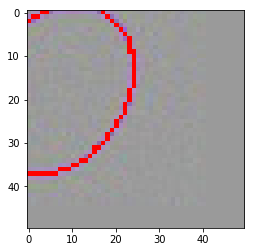

[ 1.12860764  0.08966696 -0.40683001  0.82603574]
[31. 25. 15. 12.]


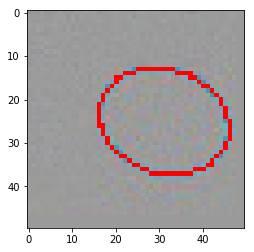

[-0.4299162   0.25409298  0.94582661 -0.27955017]
[22. 26. 22. 10.]


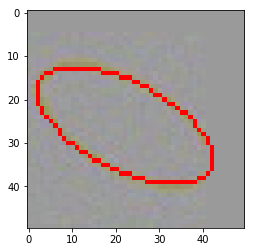

In [8]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt

def draw_ellipse(img, ellipse, denormalize=False, use_ang_bin=False):
    '''
    draw an ellipse on image
    
      ellipse - parameterization of ellipse, if denormalize=True then this should be our
         representation, if False then this should be the original representation in the
         dataset text file
      
      use_ang_bin - whether to use the angle encoded in the one-hot vector or the angle
         parameter we carry along for debugging
    '''
    img = img + mean_img
    if ellipse[P.IS_ELLIPSE] < 0.5:
        return img
    if use_ang_bin:
        ang = bin_to_ang(ellipse[P.ANG_BIN_BEG:P.ANG_BIN_END])
    else:
        ang = ellipse[P.ANG]

    print(ellipse[P.SHAPE_BEG:P.SHAPE_END])
    if denormalize:
        ellipse = np.copy(ellipse)
        ellipse[P.SHAPE_BEG:P.SHAPE_END] = (ellipse[P.SHAPE_BEG:P.SHAPE_END] * shape_std
                                            + shape_mean)
        ellipse[P.HA2] = np.exp(ellipse[P.HA2]) * ellipse[P.HA1]
        ellipse[P.SHAPE_BEG:P.SHAPE_END] = np.around(ellipse[P.SHAPE_BEG:P.SHAPE_END])
        print(ellipse[P.SHAPE_BEG:P.SHAPE_END])
    
    cv2.ellipse(img, center=(int(ellipse[P.X]), int(ellipse[P.Y])),
                axes=(int(ellipse[P.HA1]), int(ellipse[P.HA2])),
                angle=ang, startAngle=0, endAngle=360, color=(1.0, 0, 0), thickness=1)
    
    return img

ellipse_gen = EllipseGen()
imgs_batch, ellipses_batch = next(iter(ellipse_gen))
for img, ellipse in zip(imgs_batch[:3], ellipses_batch[:3]):
    plt.imshow(draw_ellipse(img, ellipse, denormalize=True, use_ang_bin=True))
    plt.show()

We train the above model with the above data for 25 epochs on an NVIDIA K80 machine hosted on GCP. The training code writes tensorboard logs so that training can be monitored using the tb server

In [ ]:
from pathlib import Path

from keras import callbacks
from keras_tqdm import TQDMNotebookCallback

Path('./logs').mkdir(exist_ok=True) 
Path('./models').mkdir(exist_ok=True) 

session_name = 'deep-ellipse'
tb_callback = callbacks.TensorBoard(log_dir='./logs/%s' % session_name, 
                                    histogram_freq=0, batch_size=BATCH_SIZE,
                                    write_graph=True, write_grads=False,
                                    write_images=True, embeddings_freq=0,
                                    embeddings_layer_names=None,
                                    embeddings_metadata=None)

ellipse_gen = EllipseGen()
model.fit_generator(iter(ellipse_gen),
                    steps_per_epoch=len(ellipse_gen),
                    epochs=25,
                    verbose=0,
                    initial_epoch=0,
                    validation_data=(imgs_test, gt_test),
                    callbacks=[tb_callback, TQDMNotebookCallback()])

model.save('./models/%s.h5' % session_name)
print('Training done!')

To evaluate the trained model, we examine the true average error (in pixels) of the coordinates and axes, and the absolute error of predicted angles (in degrees):

In [42]:
import cv2
import numpy as np
from keras.models import load_model
from matplotlib import pyplot as plt

model = load_model('./models/deep-ellipse.h5',
                   custom_objects={
                       'ellipse_loss': ellipse_loss,
                       'ellipse_detector_accuracy': ellipse_detector_accuracy,
                       'ellipse_angle_accuracy': ellipse_angle_accuracy,
                       'ellipse_shape_error': ellipse_shape_error
                   })

pred_test = model.predict(imgs_test)

is_ellipse = np.nonzero(gt_test[:,P.IS_ELLIPSE])
ellipses_test = np.squeeze(pred_test[is_ellipse, :])
gt_ellipses = np.squeeze(gt_test[is_ellipse, :])
is_ellipse_accuracy = np.count_nonzero(pred_test[:,P.IS_ELLIPSE] == 
                                       gt_test[:,P.IS_ELLIPSE]) / n_test

# calculate average error in angle difference
n_ellipses = is_ellipse[0].size
ang = bin_to_ang(ellipses_test[:, P.ANG_BIN_BEG:P.ANG_BIN_END])
ang_avg_error = np.mean((np.abs(ang - gt_ellipses[:, P.ANG]) + 180) % 360 - 180)

# average error in coordinates (pixels)
denormalize_shape(ellipses_test)
gt_test_denormalized = np.copy(gt_test)
shape_avg_error = np.mean(np.abs(ellipses_test[:, P.SHAPE_BEG:P.SHAPE_END] -
                                 gt_ellipses[:, P.SHAPE_BEG:P.SHAPE_END]), axis=0)

print('Angle avg error (degrees, percent): %.1f, %.2f\n' % (
        ang_avg_error, ang_avg_error / 180 * 100) +
      'Shape avg error (pixels): x,y=%.1f, ha1=%.1f, ha2=%.1f' % (
        (shape_avg_error[0] + shape_avg_error[1]) / 2,
        shape_avg_error[2], shape_avg_error[3]
      ))

Angle avg error (degrees, percent): 8.2, 4.56
Shape avg error (pixels): x,y=2.8, ha1=2.5, ha2=13.4


Finally, some example predictions:

[0.        0.        0.        1.0562875]
[25. 24. 17. 15.]


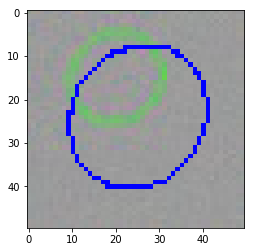

[0.         1.5165293  0.66484797 0.4543208 ]
[25. 33. 21. 14.]


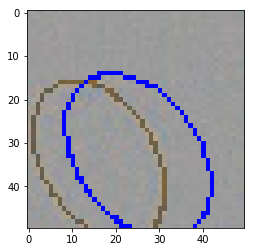

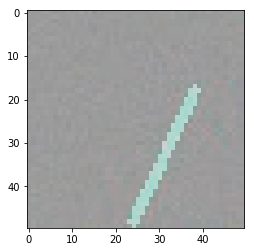

[0.         0.         0.         0.53760874]
[25. 24. 17. 12.]


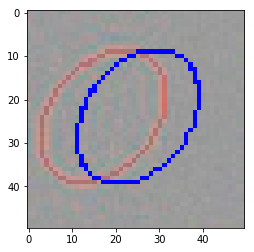

[0.        0.        1.2304978 0.5930377]
[25. 24. 23. 17.]


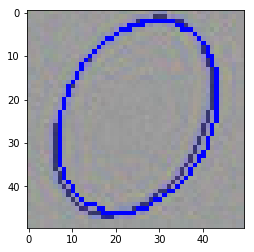

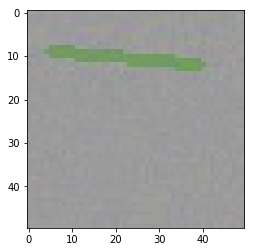

[0.8994414  0.         1.0265969  0.19357622]
[30. 24. 22. 13.]


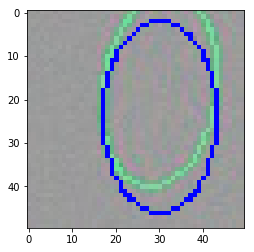

[1.072746  0.        0.        1.0746017]
[31. 24. 17. 16.]


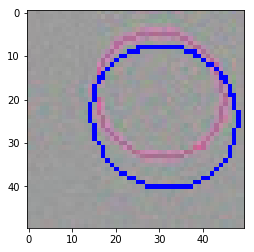

[0.         1.1984314  0.58902836 0.        ]
[25. 31. 20. 11.]


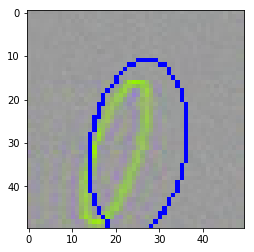

[0.         0.         0.11295378 0.35130554]
[25. 24. 18. 11.]


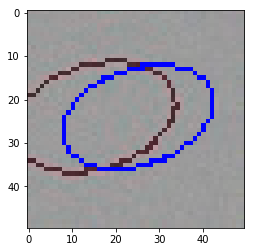

In [48]:
random_subset = np.random.randint(n_test, size=10)
for ind in list(random_subset):
    plt.imshow(draw_ellipse(imgs_test[ind], pred_test[ind, :],
                            denormalize=True, use_ang_bin=True)[:, :, ::-1])
    plt.show()

### Discussion

It's apparent the model struggles with small ellipses as well as ellipses with a low ratio of short-to-long axis length. This can be due to two reasons -

1. The lack of high resolution data in the upper levels of the model. This can be partially resolved with feature-pyramid approaches or by running "mini-regressors" on the higher-resolution feature maps in the spirit of SSD.
2. The chosen smooth-L1 loss function hardly penalizes smaller errors and so perhaps there is room to check other loss functions or at least balance the loss components differently (clearly, the angle and ellipse/non-ellipse classifiers significantly outperform the shape regressor).